In [14]:
#General libraries
import os
import pandas as pd
import numpy as np

#Graph tools
import matplotlib.pyplot as plt 
import seaborn as sns

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

#Optimization
import optuna

In [15]:
train_path = os.path.join('data', 'train.csv')
test_path = os.path.join('data', 'test.csv')
sample_submission_path = os.path.join('data', 'sample_submission.csv')

raw_train_data = pd.read_csv(train_path, index_col= 'id')
raw_test_data = pd.read_csv(test_path, index_col = 'id')
sample_submission = pd.read_csv(sample_submission_path)


In [16]:
print(raw_train_data.shape)
raw_train_data.head()

(2190, 12)


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


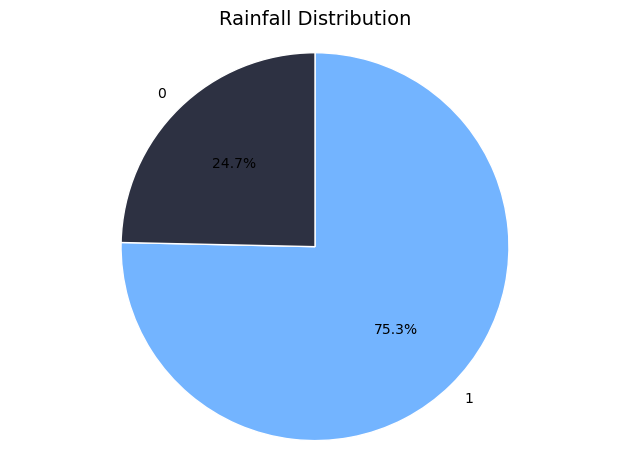

In [17]:
colors = ['#73B4FF', '#2D3142']
value_counts = raw_train_data['rainfall'].value_counts(normalize= True)
labels = value_counts.index.astype(str)
sizes = value_counts.values
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    counterclock=False,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    colors= colors
)
ax.axis('equal')

# Agregar título
ax.set_title('Rainfall Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [18]:
raw_train_data.skew()

day              0.030615
pressure         0.284062
maxtemp         -0.490890
temparature     -0.557471
mintemp         -0.649179
dewpoint        -0.997889
humidity        -0.561541
cloud           -1.339274
sunshine         0.639871
winddirection    0.708063
windspeed        0.769390
rainfall        -1.176743
dtype: float64

In [19]:
def data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['cloud'] = np.log1p(df['cloud'])
    df = df.fillna(0)

    return df
    

In [20]:
processed_train_data = data_preproccesing(raw_train_data) 
X_train = processed_train_data.drop(columns= 'rainfall')
y_train = processed_train_data['rainfall']

In [26]:
def objective(trial, X, y):
    # Define hyperparameters in a dictionary (best practice)
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 1, 10, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 100),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.5),
        'random_state': 42
    }
    
    clf = DecisionTreeClassifier(**params)
    
    # 5-split StratifiedKFold to maintain class balance
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        scores.append(roc_auc_score(y_test, pred))
    
    return np.mean(scores)
    
    

In [27]:
study = optuna.create_study(direction='maximize', sampler= optuna.samplers.TPESampler(seed= 42))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

[I 2025-03-06 14:58:00,904] A new study created in memory with name: no-name-cb8dfe8a-e8e8-4021-a975-af6a7f6f9ad4
[I 2025-03-06 14:58:00,936] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.2403950683025824, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.48495492608099716}. Best is trial 0 with value: 0.5.
[I 2025-03-06 14:58:00,952] Trial 1 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 0.5722807884690141, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.18318092164684585}. Best is trial 0 with value: 0.5.
[I 2025-03-06 14:58:00,965] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': 0.141805

In [28]:
best_params =  {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.7481768628291885, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 94, 'min_impurity_decrease': 0.02523107366013949}
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       max_features=0.7481768628291885, max_leaf_nodes=94,
                       min_impurity_decrease=0.02523107366013949,
                       min_samples_split=3)

In [29]:
X_test = data_preproccesing(raw_test_data)

In [30]:
predictions = best_model.predict(X_test)

In [31]:
sample_submission['rainfall'] = predictions

In [32]:
sample_submission.to_csv('submission.csv', index= False)